In [1]:
import numpy as np
from skimage import io, data, transform
from scipy import sparse, signal
from scipy import io as spio
import matplotlib.pyplot as plt
from img_utils import tikhonov, split_bregman, gamma_reconstruct
import dill
import time

plt.gray()
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Results
Here, I am comparing performance of the three methods on three different tasks. The first is with the convolution and no subsampling with additive noise, the second is using 10% of the data, convolving, and adding noise, and the last is using 10% of the data, but with no noise. In the case of no noise, these models are not well-defined, so instead I model it as a low-noise scenario. Instead, it would be much better handled as a sort of boundary value problem.

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


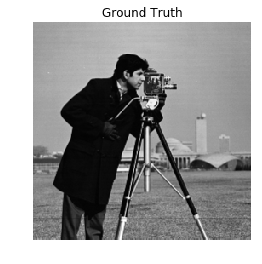

In [2]:
im = transform.resize(data.camera(), (256, 256))
plt.imshow(im)
plt.title('Ground Truth')
plt.axis('off');

In [3]:
n = np.prod(im.shape)
sigma = 0.05
np.random.seed(1234)
indices = np.random.choice(
    np.prod(im.shape), size=(int(0.1 * n)), replace=False)
# a = A = sparse.eye(np.prod(im.shape))
A = spio.loadmat('./convmat.mat')['A']
sparsea = A.tocsr()[indices, :]
fulla = A.tocsr()
np.random.seed(4514142)
sparseb = sparsea @ im.reshape(-1) + np.random.randn(sparsea.shape[0]) * sigma

np.random.seed(4514142)
fullb = fulla @ im.reshape(-1) + np.random.randn(fulla.shape[0]) * sigma

nnb = sparsea @ im.reshape(-1)
d = {
    'full': (fulla, fullb),
    'nn': (sparsea, nnb),
    'sparse': (sparsea, sparseb),
}

In [127]:
def snr(x):
    return 20 * (np.log10(1e-8 + x.mean()) -
                 np.log10(1e-8 + (x.reshape(-1) - im.reshape(-1)).std()))


def mse(x):
    return np.mean((x.reshape(-1) - im.reshape(-1))**2)


def search_tikh(A, b, regs):
    recons = {}
    for r in regs:
        t = tikhonov(A, b, r)
        recons[r] = {
            'snr': snr(t),
            'mse': mse(t),
            'img': t.reshape(*im.shape).astype(np.float32)
        }
    return recons


def search_tv(A, b, alphas, lambdas):
    recons = {}
    for a in alphas:
        for l in lambdas:
            t = split_bregman(A, b, a, l, niter=50)
            recons[(a, l)] = {
                'snr': snr(t),
                'mse': mse(t),
                'img': t.reshape(*im.shape).astype(np.float32)
            }
    return recons


def search_gamma(A, b, noiselev, alphas, thetas, eta=None):
    recons = {}
    for a in alphas:
        for o in thetas:
            t = gamma_reconstruct(
                A, b, noiselev, o, a, cgls_eta=eta, verbose=False)
            recons[(a, o)] = {
                'snr': snr(t),
                'mse': mse(t),
                'img': t.reshape(*im.shape).astype(np.float32)
            }
    return recons


def process_all(name):
    A, b = d.get(name)
    sigma = 0.00001 if name == 'nn' else 0.05
    results = {}

    start = time.time()
    results['tikhonov'] = search_tikh(A, b, [0.001, 0.01, 0.1, 1, 10])
    end = time.time()
    print('%s Tikhonov complete (%.2f s)' % (name, end - start))

    start = time.time()
    results['tv'] = search_tv(A, b, [0.1, 1], [0.01, 0.02, 0.05, 0.1, 0.2, 0.5])
    end = time.time()
    print('%s TV complete (%.2f s)' % (name, end - start))

    start = time.time()
    results['gamma'] = search_gamma(A, b, sigma, [2.001, 2.005, 2.01],
                                    [0.01, 0.1, 1], 0.0)
    end = time.time()
    print('%s Gamma complete (%.2f s)' % (name, end - start))
    return results

In [128]:
all_results = map(process_all, ['full', 'sparse', 'nn'])
all_results = {k: v for k, v in zip(['full', 'sparse', 'nn'], all_results)}

full Tikhonov complete (29.53 s)
full TV complete (405.03 s)
full Gamma complete (336.23 s)
sparse Tikhonov complete (16.79 s)
sparse TV complete (213.74 s)
sparse Gamma complete (260.13 s)
nn Tikhonov complete (17.04 s)
nn TV complete (215.01 s)
nn Gamma complete (25.60 s)


In [129]:
res = all_results

In [44]:
with open('./results.pkl', 'wb') as f:
    dill.dump(all_results, f)

In [130]:
def get_best(single_method_results):
    return max(single_method_results.items(), key=lambda x: x[1]['snr'])
optima = {}
for ds in res.keys():
    optima[ds] = {}
    for k,v in res[ds].items():
        optima[ds][k] = get_best(v)

In [131]:
pretty_names = {'nn':'No Noise', 'sparse':'Sparse', 'full':'Full'}

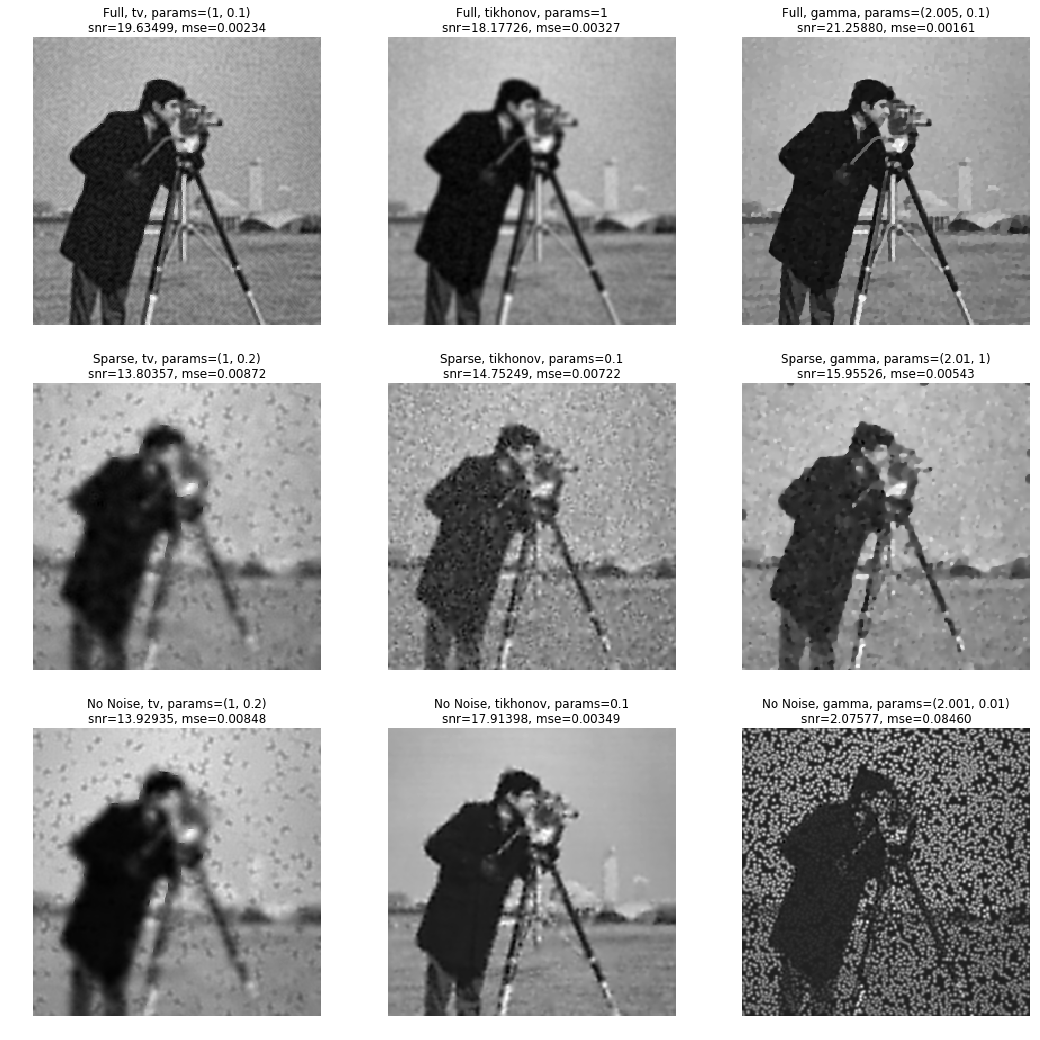

In [132]:
fig = plt.figure(figsize=(18, 18))
ordered_k = sorted(optima['full'].keys())[::-1]
for ix, (ds, ress) in enumerate(optima.items()):
    for x, k in enumerate(ordered_k):
        plt.subplot(3, 3, ix * 3 + x + 1)
        plt.imshow(ress[k][1]['img'])
        plt.axis('off')
        plt.title('%s, %s, params=%s\nsnr=%.5f, mse=%.5f' % (
            pretty_names[ds],
            k,
            ress[k][0],
            ress[k][1]['snr'],
            ress[k][1]['mse'],
        ))

### Discussion
Above, we can see the results on the three examples, two of which we expect to work: a full image with a gaussian blur and additive noise applied, an image that was subsampled (10% retained) from a the result of a gaussian blur on the original (with additive noise), and the same subsampling scheme, but without adding noise. When we do not add noise, we would not expect the methods to work very well, because our observation distribution becomes degenerate.  We can see this, especially in the case of the gamma reconstruction, where we need to assign some nonzero noise level to the difference $Ax-b$, so when the noise is zero, the probability distribution becomes a single point, which does not let the optimization techniques work. Instead, we would need to treat this as a boundary value problem, where the known pixels are specified as fixed. 

We can see that using a gamma prior results in slightly better reconstruction error than the other methods when noise is present. This is expected, because the image shows areas of fairly constant color, as expected by our specification of the prior. TV performs similarly well where the full data is known, but its performance comes at the cost of a high sensitivity to hyperparameters: a very small difference in two parameters could be the difference between a very noisy and a good image.

### "Overregularized" examples
To see what sort of structure different algorithms enforce, we can look at examples where the regularization is set to be very strong (i.e. promoting structure very different from what $b$ indicates). We can see that both the gamma and TV regularization enforce areas of comparable magnitude, with sharp jumps between, while Tikhonov blurs the image, similarly to how we might expect a gaussian filter to work. It appears here that using a gamma prior results in slightly more freedom for jumps, which is expected, because the presence of an occasional jump is not strongly penalized

In [124]:
tv_over = split_bregman(*d.get('full'), 1, 1).reshape(*im.shape)
tikh_over = tikhonov(*d.get('full'), 3).reshape(*im.shape)
gamma_over = gamma_reconstruct(*d.get('full'), sigma, 0.00001, 2.1).reshape(*im.shape)

Iteration 50 complete
Iteration 100 complete


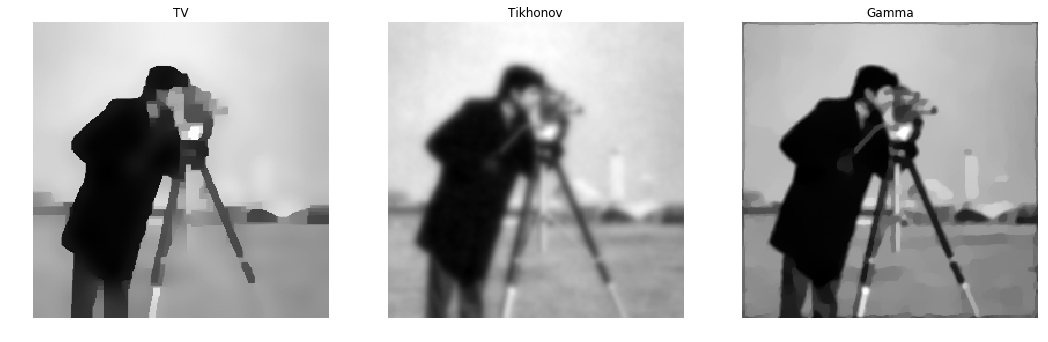

In [125]:
plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
plt.imshow(tv_over)
plt.axis('off')
plt.title('TV')

plt.subplot(1,3,2)
plt.imshow(tikh_over)
plt.axis('off')
plt.title('Tikhonov')

plt.subplot(1,3,3)
plt.imshow(gamma_over)
plt.axis('off')
plt.title('Gamma');